In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, "dataset")

CLASS_NAMES = [
    "High_Motor_Coordination_Risk",
    "Mild_Motor_Coordination_Risk"
]

CLASS_DIRS = {
    class_name: os.path.join(DATASET_DIR, class_name)
    for class_name in CLASS_NAMES
}

print("Dataset path:", DATASET_DIR)
print("Classes found:", CLASS_DIRS)


Dataset path: c:\Projects\Dyspraxia\dataset
Classes found: {'High_Motor_Coordination_Risk': 'c:\\Projects\\Dyspraxia\\dataset\\High_Motor_Coordination_Risk', 'Mild_Motor_Coordination_Risk': 'c:\\Projects\\Dyspraxia\\dataset\\Mild_Motor_Coordination_Risk'}


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.1,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)


train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 200 images belonging to 2 classes.


Found 49 images belonging to 2 classes.


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(1.0869565217391304), 1: np.float64(0.9259259259259259)}


In [6]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # transfer learning


In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


In [8]:
EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)


model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,218,917 (16.09 MB)

 Trainable params: 166,786 (651.51 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.0869565217391304), 1: np.float64(0.9259259259259259)}


In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 874ms/step - accuracy: 0.5200 - loss: 0.9114 - val_accuracy: 0.5510 - val_loss: 0.6824 - learning_rate: 3.0000e-04
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 558ms/step - accuracy: 0.4850 - loss: 0.8666 - val_accuracy: 0.4490 - val_loss: 0.8006 - learning_rate: 3.0000e-04
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 566ms/step - accuracy: 0.5000 - loss: 0.8307 - val_accuracy: 0.4490 - val_loss: 0.6894 - learning_rate: 3.0000e-04
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 548ms/step - accuracy: 0.5450 - loss: 0.8433 - val_accuracy: 0.4490 - val_loss: 0.7117 - learning_rate: 3.0000e-04
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 553ms/step - accuracy: 0.6300 - loss: 0.7124 - val_accuracy: 0.4490 - val_loss: 0.7075 - learning_rate: 9.0000e-05
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - accuracy: 0.6900 - loss: 0.6060 - val_accuracy: 0.4490 - val_loss: 0.6964 - learning_rate: 9.0000e-05
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 550ms/step - accuracy:

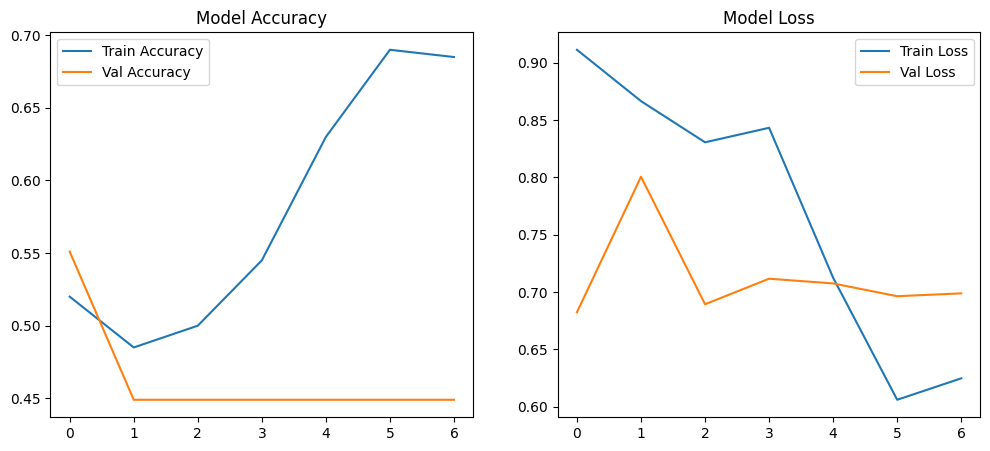

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = val_gen.classes
y_prob = model.predict(val_gen)
y_pred = np.argmax(y_prob, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(
    y_true, y_pred,
    target_names=val_gen.class_indices.keys()
))


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step  
[[ 0 22]
 [ 0 27]]
                              precision    recall  f1-score   support

High_Motor_Coordination_Risk       0.00      0.00      0.00        22
Mild_Motor_Coordination_Risk       0.55      1.00      0.71        27

                    accuracy                           0.55        49
                   macro avg       0.28      0.50      0.36        49
                weighted avg       0.30      0.55      0.39        49



c:\Projects\Dyspraxia\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Projects\Dyspraxia\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Projects\Dyspraxia\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
